# Import and misc

In [1]:
# Instal latest torch and torchaudio

In [2]:
# !pip install -qq --upgrade torch
# !pip install -qq --upgrade torchaudio
# !pip install thop

In [1]:
from typing import Tuple, Union, List, Callable, Optional
from tqdm import tqdm
from itertools import islice
import pathlib
import dataclasses

import numpy as np
import pandas as pd

import os
import random
import torch
import torch.nn.functional as F
from torch import nn
from torch import distributions
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence

import torchaudio
from IPython import display as display_

from collections import defaultdict
from IPython.display import clear_output
from matplotlib import pyplot as plt

In [4]:

# Import models
from models.blocks  import *
from models.crnn_base import *
from models.crnn_ds_small import *
from models.crnn_base_streaming import *


# Import functions from seminar
from src.dataset import *
from src.utils import *
from src.trainer import  *
from src.eval import *

In [5]:
def seed_everything(seed: int):
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
SEED = 42

seed_everything(SEED)

In [6]:
@dataclasses.dataclass
class TaskConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 4e-4
    weight_decay: float = 1e-5
    num_epochs: int = 30
    n_mels: int = 40
    cnn_out_channels: int = 8
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 32
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    temperature:int =  20
    alpha:float = 0.6
    gamma:float = 0.01
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')

# Data

In [7]:
# !wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz -O speech_commands_v0.01.tar.gz
# !mkdir speech_commands && tar -C speech_commands -xvzf speech_commands_v0.01.tar.gz 1> log

In [8]:
dataset = SpeechCommandDataset(
    path2dir='speech_commands', keywords=TaskConfig.keyword
)

### Augmentations

In [9]:
indexes = pd.Series(np.arange(len(dataset))).sample(frac=1, random_state=SEED, replace=False).values
train_indexes = indexes[:int(len(dataset) * 0.8)]
val_indexes = indexes[int(len(dataset) * 0.8):]

train_df = dataset.csv.iloc[train_indexes].reset_index(drop=True)
val_df = dataset.csv.iloc[val_indexes].reset_index(drop=True)

In [10]:
# Sample is a dict of utt, word and label
train_set = SpeechCommandDataset(csv=train_df, transform=AugsCreation())
val_set = SpeechCommandDataset(csv=val_df)

### Sampler for oversampling:

In [12]:
train_sampler = get_sampler(train_set.csv['label'].values)

###  Dataloaders

In [13]:
# Here we are obliged to use shuffle=False because of our sampler with randomness inside.

train_loader = DataLoader(train_set, batch_size=TaskConfig.batch_size,
                          shuffle=False, collate_fn=Collator(),
                          sampler=train_sampler,
                          num_workers=0, pin_memory=True)

val_loader = DataLoader(val_set, batch_size=TaskConfig.batch_size,
                        shuffle=False, collate_fn=Collator(),
                        num_workers=0, pin_memory=True)

### Creating MelSpecs on GPU for speeeed: 

In [14]:
melspec_train = LogMelspec(is_train=True, config=TaskConfig)
melspec_val = LogMelspec(is_train=False, config=TaskConfig)

In [23]:
history = defaultdict(list)

# Training

In [83]:
config = TaskConfig(hidden_size=32, num_epochs=20)
model = CRNN(config).to(config.device)

opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)


CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 32, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=32, out_features=2, bias=True)
)


In [25]:
import tempfile

def calc_params(module):
  return sum([p.numel() for p in module.parameters()])

def get_size_in_megabytes(model):
    # https://pytorch.org/tutorials/recipes/recipes/dynamic_quantization.html#look-at-model-size
    with tempfile.TemporaryFile() as f:
        torch.save(model.state_dict(), f)
        size = f.tell() / 2**20
    return size

In [26]:
[(module_name, calc_params(module)) for module_name, module in model.named_modules()]

[('', 25387),
 ('conv', 808),
 ('conv.0', 808),
 ('conv.1', 0),
 ('gru', 23424),
 ('attention', 1089),
 ('attention.energy', 1089),
 ('attention.energy.0', 1056),
 ('attention.energy.1', 0),
 ('attention.energy.2', 33),
 ('classifier', 66)]

In [29]:
# model.load_state_dict(torch.load('model.pth').state_dict())

In [27]:
#TRAIN

# for n in range(config.num_epochs):

#     train_epoch(model, opt, train_loader,
#                 melspec_train, config.device)

#     au_fa_fr = validation(model, val_loader,
#                           melspec_val, config.device)
#     history['val_metric'].append(au_fa_fr)

#     clear_output()
#     plt.plot(history['val_metric'])
#     plt.ylabel('Metric')
#     plt.xlabel('Epoch')
#     plt.grid()
#     plt.show()

#     print('END OF EPOCH', n)

In [104]:
validation(model, val_loader,
                          melspec_val, config.device)

In [32]:
# torch.save(model.state_dict(), 'model.pth')

In [15]:
# model_streaming = CRNNStreaming(config).to('cpu')
# model_streaming.load_state_dict(torch.load('model_base.pth', map_location=torch.device('cpu')))

In [16]:
# sm = torch.jit.script(model_streaming)
# sm.save("model_streaming.pt")


### Reproduce

In [125]:
from torch.autograd import Variable
def distill(teacher_model, student_model, train_loader, log_melspec, epoch_number=5, alpha=0.5, temperature=2):
    def error_and_output(var_X_batch, var_y_batch):
        kldloss = nn.KLDivLoss()  
        celoss = nn.CrossEntropyLoss()
        
        teacher_logits = teacher_model(var_X_batch)
        student_logits = student_model(var_X_batch)
        
        soft_predictions = F.log_softmax( student_logits / temperature, dim=1 )
        soft_labels = F.softmax( teacher_logits / temperature, dim=1 )
        distillation_loss = kldloss(soft_predictions, soft_labels)
        
        student_loss = celoss(student_logits, var_y_batch)
        
        return distillation_loss * alpha + student_loss * (1 - alpha), student_logits
    
    optimizer = torch.optim.Adam(student_model.parameters())
    student_model.train()
    teacher_model.train()
    
    for epoch in range(epoch_number):
        correct = 0
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            X_batch = log_melspec(X_batch.to("cuda"))
            y_batch = y_batch.to("cuda")
            
            optimizer.zero_grad()
            loss, output = error_and_output(X_batch, y_batch)
            loss.backward()
            optimizer.step()

            predicted = torch.max(output.data, 1)[1] 
            correct += (predicted == y_batch).sum()
            if batch_idx % 200 == 0:
                print('Epoch : {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy:{:.3f}%'.format(
                    epoch, batch_idx*len(X_batch), len(train_loader.dataset), 100.*batch_idx / len(train_loader),\
                     loss.data, float(correct*100) / float(128*(batch_idx+1))))
                

def error_and_output( var_X_batch, var_y_batch, teacher_model,student_model, temperature, alpha,gamma, ):
    kldloss = nn.KLDivLoss(reduction="batchmean")  
    celoss = nn.CrossEntropyLoss()
    
    teacher_logits = teacher_model(var_X_batch)
    student_logits = student_model(var_X_batch)
    
    soft_predictions = F.log_softmax( student_logits / temperature, dim=1 )
    soft_labels = F.softmax( teacher_logits / temperature, dim=1 )
    out_loss = kldloss(soft_predictions, soft_labels)

    pooling1 = nn.AvgPool2d(kernel_size=4)
    teacher_model_gru_w1 = pooling1(teacher_model.gru.weight_hh_l0.detach().unsqueeze(0)).squeeze(0)

    pooling2 = nn.AvgPool2d(kernel_size=(4,1))
    teacher_model_gru_w2 = pooling2(teacher_model.gru.weight_ih_l0.detach().unsqueeze(0)).squeeze(0)

    rnn_loss1 = nn.functional.mse_loss(student_model.gru.weight_hh_l0.detach(), teacher_model_gru_w1)
    rnn_loss2 = nn.functional.mse_loss(student_model.gru.weight_ih_l0.detach(), teacher_model_gru_w2)

    pooling3 = nn.MaxPool2d(kernel_size=(4,4))
    att_h1 = pooling3(teacher_model.attention.energy[0].weight.detach().unsqueeze(0)).squeeze(0)
    pooling4 = nn.MaxPool2d(kernel_size=(1,4))
    att_h2 = pooling4(teacher_model.attention.energy[2].weight.detach().unsqueeze(0)).squeeze(0)

    attention_loss1 = nn.functional.mse_loss(student_model.attention.energy[0].weight.detach(), att_h1)
    attention_loss2 = nn.functional.mse_loss(student_model.attention.energy[2].weight.detach(), att_h2)

    student_loss = celoss(student_logits, var_y_batch)
    
    return out_loss * alpha + student_loss * (1 - alpha) + gamma*(rnn_loss1+rnn_loss2) + gamma*(attention_loss1 + attention_loss2), student_logits
    



In [127]:
micro_config

TaskConfig(keyword='sheila', batch_size=128, learning_rate=0.0004, weight_decay=1e-05, num_epochs=10, n_mels=40, cnn_out_channels=8, kernel_size=(5, 20), stride=(2, 8), hidden_size=8, gru_num_layers=1, bidirectional=False, num_classes=2, sample_rate=16000, temperature=20, alpha=0.6, gamma=0.5, device=device(type='cpu'))

In [146]:
def distill_epoch(student_model, teacher_model, opt, loader, log_melspec, device,temperature,alpha,gamma):
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()
        loss, logits = error_and_output(batch, labels,  teacher_model,student_model, temperature, alpha, gamma,)
        probs = F.softmax(logits, dim=-1)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()

        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc

def distill(student_model, teacher_model, opt, train_loader, val_loader, melspec_train, melspec_val, config ):
    student_model.train()
    teacher_model.eval()
    
    for n in range(config.num_epochs):

        distill_epoch(student_model, teacher_model, opt, train_loader,
                    melspec_train, config.device, config.temperature, config.alpha, config.gamma)

        au_fa_fr = validation(student_model, val_loader,
                            melspec_val, config.device)
        history['val_metric'].append(au_fa_fr)

        clear_output()
        plt.plot(history['val_metric'])
        plt.ylabel('Metric')
        plt.xlabel('Epoch')
        plt.grid()
        plt.show()

        print('END OF EPOCH', n)

In [147]:
micro_config = TaskConfig(
    hidden_size=8,
    cnn_out_channels=8,
    gru_num_layers=1,
    num_epochs=15,
    temperature=20,
    alpha=0.6,
    gamma=0.05,
    )

student_model = CRNNmicro(micro_config).to(micro_config.device)


base_config = TaskConfig(hidden_size=32)
teacher_model = CRNN(base_config).to(base_config.device)
teacher_model.load_state_dict(torch.load('checkpoints/model_base.pth', map_location=torch.device('cpu')))

optimizer = torch.optim.Adam(student_model.parameters(),
                             lr=micro_config.learning_rate,
                             weight_decay=micro_config.weight_decay)

melspec = LogMelspec(is_train=False, config=micro_config)
history = defaultdict(list)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


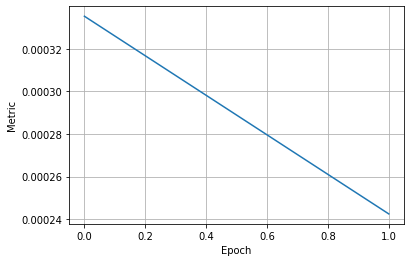

END OF EPOCH 1


  3%|▎         | 11/405 [00:03<02:20,  2.80it/s]


KeyboardInterrupt: 

In [148]:
distill(student_model, teacher_model, optimizer, train_loader, val_loader, melspec, melspec, micro_config )

In [ ]:
#distill_layerwise(model.to('cuda'), student_model, train_loader,log_melspec=melspec_val, epoch_number=15, alpha=0.65,gamma=0.05, temperature=20)

Epoch : 0 [0/51776 (0%)]	Loss: 0.225273	 Accuracy:50.000%
Epoch : 0 [25600/51776 (49%)]	Loss: 0.085386	 Accuracy:88.099%
Epoch : 0 [51200/51776 (99%)]	Loss: 0.052793	 Accuracy:91.313%
Epoch : 1 [0/51776 (0%)]	Loss: 0.056604	 Accuracy:96.875%
Epoch : 1 [25600/51776 (49%)]	Loss: 0.064278	 Accuracy:95.281%
Epoch : 1 [51200/51776 (99%)]	Loss: 0.055870	 Accuracy:95.749%
Epoch : 2 [0/51776 (0%)]	Loss: 0.056073	 Accuracy:97.656%
Epoch : 2 [25600/51776 (49%)]	Loss: 0.056486	 Accuracy:96.105%
Epoch : 2 [51200/51776 (99%)]	Loss: 0.065301	 Accuracy:96.337%
Epoch : 3 [0/51776 (0%)]	Loss: 0.057205	 Accuracy:96.875%
Epoch : 3 [25600/51776 (49%)]	Loss: 0.057141	 Accuracy:96.875%
Epoch : 3 [51200/51776 (99%)]	Loss: 0.064901	 Accuracy:97.025%
Epoch : 4 [0/51776 (0%)]	Loss: 0.057685	 Accuracy:99.219%
Epoch : 4 [25600/51776 (49%)]	Loss: 0.084014	 Accuracy:97.295%
Epoch : 4 [51200/51776 (99%)]	Loss: 0.070976	 Accuracy:97.237%
Epoch : 5 [0/51776 (0%)]	Loss: 0.062046	 Accuracy:98.438%
Epoch : 5 [25600/51776

In [135]:
validation(student_model, val_loader,
                          melspec_val, config.device)

102it [00:05, 18.17it/s]


6.482546937372527e-05

In [ ]:
# config = TaskConfig(hidden_size=16)
# model = CRNN(config).to(config.device)

# here we specify weights data format and layers that are to be quantized
quantized_model = torch.quantization.quantize_dynamic(
    student_model.to("cpu"), {torch.nn.Linear, torch.nn.Conv2d, torch.nn.GRU, "dsconv.0.depthwise","dsconv.0.pointwise" }, dtype=torch.torch.qint8
)
print(quantized_model)

CRNNmicro(
  (dsconv): Sequential(
    (0): DSConv2d(
      (depthwise): Conv2d(1, 1, kernel_size=(5, 20), stride=(2, 8))
      (pointwise): Conv2d(1, 8, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): DynamicQuantizedGRU(144, 8, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): DynamicQuantizedLinear(in_features=8, out_features=8, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
      (1): Tanh()
      (2): DynamicQuantizedLinear(in_features=8, out_features=1, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
    )
  )
  (classifier): DynamicQuantizedLinear(in_features=8, out_features=2, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
)


In [ ]:
test_config = TaskConfig(device='cpu')

melspec_test = LogMelspec(is_train=False, config=test_config)
validation(quantized_model.to('cpu'), val_loader,
                          melspec_test, test_config.device)

102it [00:09, 11.22it/s]


6.659783100531842e-05

In [ ]:
# pruned_model = model
# pruned_model.prune(rate=0.7)
# test_config = TaskConfig(device='cpu')

# melspec_test = LogMelspec(is_train=False, config=test_config)
# validation(pruned_model.to('cpu'), val_loader,
#                           melspec_test, test_config.device)

102it [00:08, 11.81it/s]


0.0001732319387323825

In [ ]:
from thop import profile  # !pip install thop
from thop import clever_format

# batch, label = next(iter(train_loader))
sample = torch.randn(1, 40, 101).to('cpu')#.unsqueeze(0)
base = profile(model.to('cpu'), (sample,))
distilled = profile(student_model.to('cpu'), (sample,))
distilled_quantized = profile(quantized_model.to('cpu'), (sample,))   # -> (6.0 MACs, 3.0 parameters)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.


In [ ]:
base[0], distilled[0], distilled_quantized[0], base[0]/distilled[0], base[0]/distilled_quantized[0]

(432672.0, 63464.0, 21384.0, 6.817597378041095, 20.2334455667789)

In [ ]:
base = get_size_in_megabytes(model)
distilled = get_size_in_megabytes(student_model)
distilled_quantized = get_size_in_megabytes(quantized_model)
base, distilled, distilled_quantized,  base / distilled_quantized

(0.10348224639892578,
 0.02163410186767578,
 0.01869678497314453,
 5.534761540423362)